# RANZCR 1st Place Solution Training Classification Model

Hi all,

We're very exciting to writing this notebook and the summary of our solution here.

Our final pipeline has 4 training stages but the minimal pipeline I show here has only 2 stages.

The 5-fold model trained with this minimal pipeline is sufficient to achieve CV 0.968-0.969 and pub/pvt LB 0.972

I published 3 notebooks to demonstrate how our MINIMAL pipeline works.

* Stage1: Segmentation (https://www.kaggle.com/haqishen/ranzcr-1st-place-soluiton-seg-model-small-ver)
* Stage2: Classification (This notebook)
* Inference (https://www.kaggle.com/haqishen/ranzcr-1st-place-soluiton-inference-small-ver)

This notebook shows how we can train a **classification** model using the original image, and the predicted mask of the segmentation model which we trained in stage 1.

I've trained 5 fold segmentation models (b1 1024, exactly the same setting to the stage1 notebook） locally and uploaded the predicted masks here: https://www.kaggle.com/haqishen/ranzcr-pred-masks-qishen

To get a similar performance of a single classification model to ours, you only need to do:

* set DEBUG to `False`
* train for 30 epochs for each fold
* change the model type to effnet-b3/b4/b5

In this minimal pipeline we do not use external data, so the classification model input is **5ch**, original image as 3ch, predicted masks as 2ch (w/o trachea bifurcation channel)

It tooks around 3h for training a single fold classification models by this setting (b1 512)

Finally I got CV score: `0.96788` by B1 1024 segmentationg model + B1 512 classification model

You should be able to reach CV 0.968-0.969 by simply using B5-B7 backbone to train segmentation model and use B3-B5 backbone to train classification model, without changing any other setting.

Our brief summary of winning solution: https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/discussion/226633

# Main Ideas

* amp
* combine original image (3ch) and predicted mask (3ch) as 5ch input
* optimized augmentation methods
* use CrossEntropy for ETT tube
* warmup + cosine scheduler

# Thanks!

In [1]:
!pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [2]:
DEBUG = True

# Add smp & timm to kernel w/o Internet
import sys
sys.path = [
    '../input/smp20210127/segmentation_models.pytorch-master/segmentation_models.pytorch-master/',
    '../input/smp20210127/EfficientNet-PyTorch-master/EfficientNet-PyTorch-master',
    '../input/smp20210127/pytorch-image-models-master/pytorch-image-models-master',
    '../input/smp20210127/pretrained-models.pytorch-master/pretrained-models.pytorch-master',
] + sys.path

In [3]:
# libraries
import os
import time
import random
import numpy as np
import pandas as pd
import subprocess
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score
from warmup_scheduler import GradualWarmupScheduler
import albumentations
import timm
from tqdm.notebook import tqdm
import torch.cuda.amp as amp
import warnings

warnings.simplefilter('ignore')
scaler = amp.GradScaler()
device = torch.device('cuda')

In [4]:
# Dual Cutout implementations
class CutoutV2(albumentations.DualTransform):
    def __init__(
        self,
        num_holes=8,
        max_h_size=8,
        max_w_size=8,
        fill_value=0,
        always_apply=False,
        p=0.5,
    ):
        super(CutoutV2, self).__init__(always_apply, p)
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.fill_value = fill_value

    def apply(self, image, fill_value=0, holes=(), **params):
        return albumentations.functional.cutout(image, holes, fill_value)

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2]

        holes = []
        for _n in range(self.num_holes):
            y = random.randint(0, height)
            x = random.randint(0, width)

            y1 = np.clip(y - self.max_h_size // 2, 0, height)
            y2 = np.clip(y1 + self.max_h_size, 0, height)
            x1 = np.clip(x - self.max_w_size // 2, 0, width)
            x2 = np.clip(x1 + self.max_w_size, 0, width)
            holes.append((x1, y1, x2, y2))

        return {"holes": holes}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return ("num_holes", "max_h_size", "max_w_size")

# Config

In [5]:
kernel_type = 'enetb1_5ch_512_lr3e4_bs32_30epo'
enet_type = 'tf_efficientnet_b1_ns'
data_dir = '../input/ranzcr-clip-catheter-line-classification'
num_workers = 2
num_classes = 12
n_ch = 5
image_size = 512
batch_size = 32
init_lr = 3e-4
warmup_epo = 1
# If DEBUG == True, only run 3 epochs per fold
cosine_epo = 29 if not DEBUG else 2
n_epochs = warmup_epo + cosine_epo
loss_weights = [1., 9.]
image_folder = 'train'
mask_folder = '../input/ranzcr-pred-masks-qishen/mask_unet++b1_2cbce_1024T15tip_lr1e4_bs4_augv2_30epo/'

log_dir = '../logs'
model_dir = '../models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
log_file = os.path.join(log_dir, f'log_{kernel_type}.txt')

In [6]:
df_train = pd.read_csv('../input/ranzcr-fold/train_v2.csv')

# If DEBUG == True, use only 100 samples to run.
df_train = pd.concat([
    df_train.query('fold == 0').sample(20),
    df_train.query('fold == 1').sample(20),
    df_train.query('fold == 2').sample(20),
    df_train.query('fold == 3').sample(20),
    df_train.query('fold == 4').sample(20),
]) if DEBUG else df_train

no_ETT = (df_train[['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal']].values.max(1) == 0).astype(int)
df_train.insert(4, column='no_ETT', value=no_ETT)

# Define Dataset

In [7]:
class RANZCRDatasetCLS(Dataset):

    def __init__(self, df, mode, transform=None):

        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = cv2.imread(os.path.join(data_dir, image_folder, row.StudyInstanceUID + '.jpg'))[:, :, ::-1]
        mask = cv2.imread(os.path.join(mask_folder, row.StudyInstanceUID + '.png')).astype(np.float32)[:,:,:2]

        res = self.transform(image=image, mask=mask)
        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.
        mask = res['mask'].astype(np.float32).transpose(2, 0, 1) / 255.

        image = np.concatenate([image, mask], 0)

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            label = row[[
                'ETT - Abnormal',
                'ETT - Borderline',
                'ETT - Normal',
                'no_ETT',
                'NGT - Abnormal',
                'NGT - Borderline',
                'NGT - Incompletely Imaged',
                'NGT - Normal',
                'CVC - Abnormal',
                'CVC - Borderline',
                'CVC - Normal',
                'Swan Ganz Catheter Present'
            ]].values.astype(float)
            return torch.tensor(image).float(), torch.tensor(label).float()

# Augmentations

In [8]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.2, p=0.75),
    albumentations.RandomContrast(limit=0.2, p=0.75),

    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.75),

    albumentations.HueSaturationValue(hue_shift_limit=40, sat_shift_limit=40, val_shift_limit=0, p=0.75),
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=30, border_mode=0, p=0.75),
    CutoutV2(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.75),
])
transforms_val = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

# Visualization

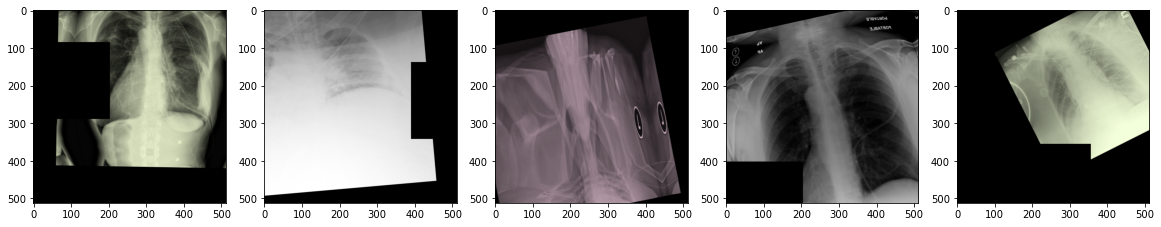

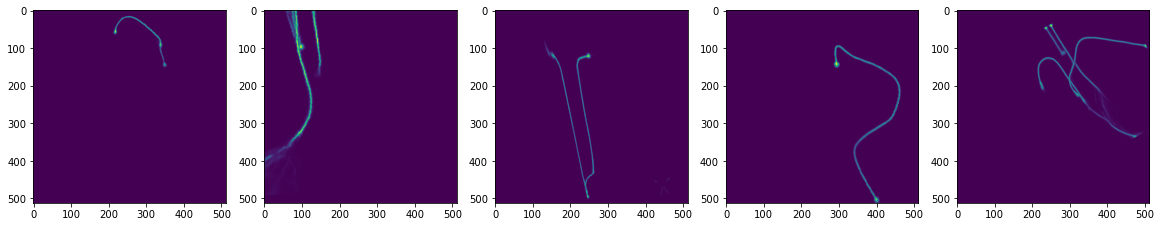

In [9]:
df_show = df_train.sample(10)
dataset_show = RANZCRDatasetCLS(df_show, 'train', transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

f, axarr = plt.subplots(1,5)
imgs = []
for p in range(5):
    img, label = dataset_show[p]
    imgs.append(img)
    axarr[p].imshow(img[:3].transpose(0, 1).transpose(1,2))

f, axarr = plt.subplots(1,5)
for p in range(5):
    axarr[p].imshow(imgs[p][3:].sum(0))

# Model

In [10]:
class enetv2(nn.Module):
    def __init__(self, enet_type, out_dim):
        super(enetv2, self).__init__()
        self.enet = timm.create_model(enet_type, True)
        self.dropout = nn.Dropout(0.5)
        self.enet.conv_stem.weight = nn.Parameter(self.enet.conv_stem.weight.repeat(1,n_ch//3+1,1,1)[:, :n_ch])
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        h = self.myfc(self.dropout(x))
        return h

m = enetv2(enet_type, num_classes)
m(torch.rand(2,n_ch,image_size, image_size))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_ns-99dd0c41.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_ns-99dd0c41.pth


tensor([[ 0.0562, -0.1572,  0.0109,  0.1508, -0.0964,  0.0425, -0.1232, -0.0359,
         -0.0273,  0.1380,  0.0465,  0.3386],
        [ 0.0874,  0.1450, -0.0897,  0.0716, -0.0686,  0.0112,  0.0007, -0.0039,
          0.0239,  0.0336,  0.0047,  0.0060]], grad_fn=<AddmmBackward>)

# Loss

In [11]:
bce = nn.BCEWithLogitsLoss()
ce = nn.CrossEntropyLoss()


def criterion(logits, targets, lw=loss_weights):
    loss1 = ce(logits[:, :4], targets[:, :4].argmax(1)) * lw[0]
    loss2 = bce(logits[:, 4:], targets[:, 4:]) * lw[1]
    return (loss1 + loss2) / sum(lw)

# LR Scheduler

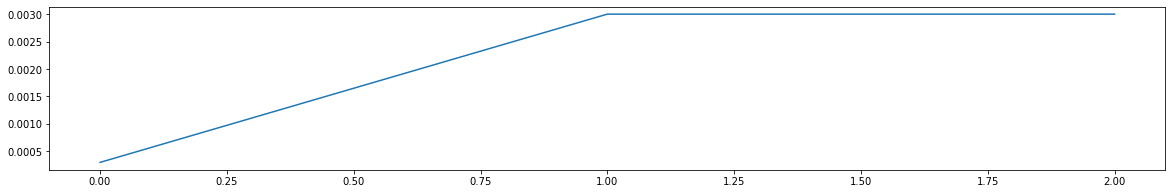

In [12]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

optimizer = optim.Adam(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

# Train & Validation Function

In [13]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, targets) in bar:

        optimizer.zero_grad()
        data, targets = data.to(device), targets.to(device)

        with amp.autocast():
            logits = model(data)
            loss = criterion(logits, targets)
        scaler.scale(loss).backward() 
        scaler.step(optimizer)
        scaler.update()

        loss_np = loss.item()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-50:]) / min(len(train_loss), 50)
        bar.set_description('loss: %.4f, smth: %.4f' % (loss_np, smooth_loss))

    return np.mean(train_loss)


def valid_epoch(model, loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    TARGETS = []
    with torch.no_grad():
        for (data, targets) in tqdm(loader):
            data, targets = data.to(device), targets.to(device)
            logits = model(data)
            loss = criterion(logits, targets)
            val_loss.append(loss.item())
            LOGITS.append(logits.cpu())
            TARGETS.append(targets.cpu())
            
    val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS)
    LOGITS[:, :4] = LOGITS[:, :4].softmax(1)
    LOGITS[:, 4:] = LOGITS[:, 4:].sigmoid()
    TARGETS = torch.cat(TARGETS).numpy()

    if get_output:
        return LOGITS
    else:
        aucs = []
        for cid in range(num_classes):
            if cid == 3: continue
            try:
                aucs.append( roc_auc_score(TARGETS[:, cid], LOGITS[:, cid]) )
            except:
                aucs.append(0.5)
        return val_loss, aucs

# Run!

In [14]:
def run(fold):
    content = 'Fold: ' + str(fold)
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')
    train_ = df_train.query(f'fold!={fold}').copy()
    valid_ = df_train.query(f'fold=={fold}').copy()

    dataset_train = RANZCRDatasetCLS(train_, 'train', transform=transforms_train)
    dataset_valid = RANZCRDatasetCLS(valid_, 'valid', transform=transforms_val)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = enetv2(enet_type, num_classes)
    model = model.to(device)
    aucs_max = 0
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')

    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss, aucs = valid_epoch(model, valid_loader)

        content = time.ctime() + ' ' + f'Fold {fold} Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.4f}, valid loss: {(val_loss):.4f}, aucs: {np.mean(aucs):.4f}.'
        content += '\n' + ' '.join([f'{x:.4f}' for x in aucs])
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if aucs_max < np.mean(aucs):
            print('aucs increased ({:.6f} --> {:.6f}).  Saving model ...'.format(aucs_max, np.mean(aucs)))
            torch.save(model.state_dict(), model_file)
            aucs_max = np.mean(aucs)

    torch.save(model.state_dict(), os.path.join(model_dir, f'{kernel_type}_model_fold{fold}.pth'))


In [15]:
for fold in range(5):
    run(fold)

Fold: 0
Fri Mar 19 04:48:32 2021 Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:48:48 2021 Fold 0 Epoch 1, lr: 0.0003000, train loss: 0.7293, valid loss: 0.7511, aucs: 0.6307.
0.5000 0.5000 0.8333 1.0000 0.5000 0.8421 0.5000 0.5789 0.5833 0.4688 0.6316
aucs increased (0.000000 --> 0.630732).  Saving model ...
Fri Mar 19 04:48:48 2021 Epoch: 2


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:49:03 2021 Fold 0 Epoch 2, lr: 0.0030000, train loss: 0.4915, valid loss: 0.5929, aucs: 0.6217.
0.5000 0.5000 0.9444 0.8947 0.5000 0.7895 0.5000 0.5789 0.4762 0.3125 0.8421
Fri Mar 19 04:49:03 2021 Epoch: 3


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:49:17 2021 Fold 0 Epoch 3, lr: 0.0030000, train loss: 0.3627, valid loss: 0.4438, aucs: 0.5471.
0.5000 0.5000 0.7778 0.6316 0.5000 0.2632 0.5000 0.9474 0.3214 0.2344 0.8421
Fold: 1
Fri Mar 19 04:49:17 2021 Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:49:32 2021 Fold 1 Epoch 1, lr: 0.0003000, train loss: 0.7432, valid loss: 0.7535, aucs: 0.6374.
0.5000 0.6842 0.6400 0.5000 0.7895 0.9474 0.6275 0.6316 0.6310 0.4286 0.6316
aucs increased (0.000000 --> 0.637380).  Saving model ...
Fri Mar 19 04:49:33 2021 Epoch: 2


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:49:47 2021 Fold 1 Epoch 2, lr: 0.0030000, train loss: 0.5183, valid loss: 0.8226, aucs: 0.6473.
0.5000 0.6842 0.7200 0.5000 0.8947 0.7368 0.6275 0.4737 0.5833 0.4524 0.9474
aucs increased (0.637380 --> 0.647273).  Saving model ...
Fri Mar 19 04:49:47 2021 Epoch: 3


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:50:01 2021 Fold 1 Epoch 3, lr: 0.0030000, train loss: 0.3565, valid loss: 1.4222, aucs: 0.6817.
0.5000 0.9474 0.6400 0.5000 0.8421 0.9474 0.8824 0.3684 0.5119 0.4643 0.8947
aucs increased (0.647273 --> 0.681686).  Saving model ...
Fold: 2
Fri Mar 19 04:50:02 2021 Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:50:17 2021 Fold 2 Epoch 1, lr: 0.0003000, train loss: 0.7385, valid loss: 0.7549, aucs: 0.5073.
0.5000 0.5000 0.5312 0.5000 0.5000 0.6719 0.6389 0.0000 0.7976 0.3095 0.6316
aucs increased (0.000000 --> 0.507340).  Saving model ...
Fri Mar 19 04:50:17 2021 Epoch: 2


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:50:32 2021 Fold 2 Epoch 2, lr: 0.0030000, train loss: 0.5002, valid loss: 0.6300, aucs: 0.6017.
0.5000 0.5000 0.8906 0.5000 0.5000 0.9375 0.5556 0.1579 0.7381 0.6548 0.6842
aucs increased (0.507340 --> 0.601695).  Saving model ...
Fri Mar 19 04:50:32 2021 Epoch: 3


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:50:47 2021 Fold 2 Epoch 3, lr: 0.0030000, train loss: 0.3635, valid loss: 1.2214, aucs: 0.5701.
0.5000 0.5000 0.9219 0.5000 0.5000 0.5469 0.5833 0.6842 0.4048 0.3929 0.7368
Fold: 3
Fri Mar 19 04:50:48 2021 Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:51:02 2021 Fold 3 Epoch 1, lr: 0.0003000, train loss: 0.7376, valid loss: 0.7245, aucs: 0.6081.
0.5000 0.5000 0.4400 0.5000 0.5000 0.8889 0.8611 0.5867 0.3929 0.5200 1.0000
aucs increased (0.000000 --> 0.608139).  Saving model ...
Fri Mar 19 04:51:02 2021 Epoch: 2


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:51:18 2021 Fold 3 Epoch 2, lr: 0.0030000, train loss: 0.4967, valid loss: 0.7022, aucs: 0.6438.
0.5000 0.5000 0.7733 0.5000 0.5000 0.9444 0.8056 0.4933 0.5476 0.5700 0.9474
aucs increased (0.608139 --> 0.643787).  Saving model ...
Fri Mar 19 04:51:18 2021 Epoch: 3


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:51:33 2021 Fold 3 Epoch 3, lr: 0.0030000, train loss: 0.3134, valid loss: 1.5241, aucs: 0.6336.
0.5000 0.5000 0.8667 0.5000 0.5000 0.9167 0.9722 0.4800 0.3690 0.4700 0.8947
Fold: 4
Fri Mar 19 04:51:33 2021 Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:51:48 2021 Fold 4 Epoch 1, lr: 0.0003000, train loss: 0.7326, valid loss: 0.7416, aucs: 0.3799.
0.5000 0.1053 0.5000 0.5000 0.5000 0.4737 0.1667 0.1053 0.1961 0.6316 0.5000
aucs increased (0.000000 --> 0.379867).  Saving model ...
Fri Mar 19 04:51:48 2021 Epoch: 2


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:52:03 2021 Fold 4 Epoch 2, lr: 0.0030000, train loss: 0.5272, valid loss: 0.8011, aucs: 0.7198.
0.5000 0.9474 0.8438 0.5000 0.5000 0.8947 0.8690 1.0000 0.7843 0.5789 0.5000
aucs increased (0.379867 --> 0.719833).  Saving model ...
Fri Mar 19 04:52:03 2021 Epoch: 3


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fri Mar 19 04:52:18 2021 Fold 4 Epoch 3, lr: 0.0030000, train loss: 0.3418, valid loss: 1.1080, aucs: 0.7114.
0.5000 0.8947 0.9375 0.5000 0.5000 0.9474 0.8929 1.0000 0.7843 0.3684 0.5000


# Analysis

In [16]:
dfs = []
LOGITS = []

for fold in range(5):
    valid_ = df_train.query(f'fold=={fold}').copy().reset_index(drop=True)
    dfs.append(valid_)
    dataset_valid = RANZCRDatasetCLS(valid_, 'valid', transform=transforms_val)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = enetv2(enet_type, num_classes)
    model = model.to(device)
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')
    model.load_state_dict(torch.load(model_file), strict=True)
    model.eval()
    
    outputs = valid_epoch(model, valid_loader, get_output=True)
    # rank prediction
    outputs = pd.DataFrame(outputs.numpy()).rank(pct=True).values
    LOGITS.append(outputs)

dfs = pd.concat(dfs).reset_index(drop=True)
LOGITS = np.concatenate(LOGITS)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
aucs = []
for cid in range(num_classes):
    if cid == 3: continue
    aucs.append( roc_auc_score(dfs.values[:,1:-3].astype(float)[:, cid], LOGITS[:, cid]) )
print('oof cv:', np.mean(aucs))

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# Appendix: My Local Training Log Fold 0

You should get similar log to mine only by changing DEBUG = False and train on your local machine with >= 16GB GPU.

```
Thu Mar 18 09:20:58 2021 Epoch 1, lr: 0.0003000, train loss: 0.2412, valid loss: 0.1794, aucs: 0.9323.
0.9358 0.9338 0.9857 0.9509 0.9435 0.9768 0.9804 0.8689 0.7919 0.8894 0.9977
Thu Mar 18 09:26:52 2021 Epoch 2, lr: 0.0030000, train loss: 0.2339, valid loss: 0.1674, aucs: 0.9339.
0.9106 0.9435 0.9873 0.9349 0.9305 0.9754 0.9844 0.8759 0.8265 0.9060 0.9974
Thu Mar 18 09:32:48 2021 Epoch 3, lr: 0.0030000, train loss: 0.2071, valid loss: 0.1754, aucs: 0.9421.
0.9118 0.9458 0.9906 0.9604 0.9606 0.9785 0.9839 0.8981 0.8351 0.9004 0.9976
Thu Mar 18 09:38:35 2021 Epoch 4, lr: 0.0029649, train loss: 0.1994, valid loss: 0.1714, aucs: 0.9415.
0.9168 0.9501 0.9893 0.9509 0.9549 0.9776 0.9819 0.8849 0.8417 0.9091 0.9991
Thu Mar 18 09:44:21 2021 Epoch 5, lr: 0.0029215, train loss: 0.1945, valid loss: 0.1608, aucs: 0.9445.
0.9219 0.9558 0.9897 0.9632 0.9650 0.9791 0.9847 0.8886 0.8347 0.9075 0.9994
Thu Mar 18 09:49:59 2021 Epoch 6, lr: 0.0028614, train loss: 0.1902, valid loss: 0.1552, aucs: 0.9499.
0.9485 0.9469 0.9877 0.9765 0.9642 0.9821 0.9865 0.8922 0.8544 0.9126 0.9975
Thu Mar 18 09:55:53 2021 Epoch 7, lr: 0.0027853, train loss: 0.1856, valid loss: 0.1705, aucs: 0.9474.
0.9260 0.9523 0.9895 0.9654 0.9659 0.9827 0.9861 0.8923 0.8437 0.9187 0.9990
Thu Mar 18 10:01:41 2021 Epoch 8, lr: 0.0026941, train loss: 0.1819, valid loss: 0.1585, aucs: 0.9476.
0.9162 0.9528 0.9908 0.9620 0.9660 0.9830 0.9870 0.9027 0.8516 0.9124 0.9993
Thu Mar 18 10:07:21 2021 Epoch 9, lr: 0.0025890, train loss: 0.1802, valid loss: 0.1640, aucs: 0.9456.
0.9127 0.9581 0.9914 0.9463 0.9445 0.9812 0.9846 0.9077 0.8576 0.9183 0.9990
Thu Mar 18 10:13:02 2021 Epoch 10, lr: 0.0024711, train loss: 0.1775, valid loss: 0.1656, aucs: 0.9481.
0.9393 0.9594 0.9914 0.9624 0.9631 0.9802 0.9823 0.9023 0.8401 0.9100 0.9990
Thu Mar 18 10:18:39 2021 Epoch 11, lr: 0.0023418, train loss: 0.1742, valid loss: 0.1444, aucs: 0.9550.
0.9276 0.9625 0.9919 0.9721 0.9718 0.9851 0.9878 0.9105 0.8741 0.9223 0.9993
Thu Mar 18 10:24:15 2021 Epoch 12, lr: 0.0022026, train loss: 0.1721, valid loss: 0.1580, aucs: 0.9554.
0.9355 0.9607 0.9922 0.9783 0.9654 0.9851 0.9891 0.9086 0.8714 0.9246 0.9986
Thu Mar 18 10:29:58 2021 Epoch 13, lr: 0.0020552, train loss: 0.1699, valid loss: 0.1447, aucs: 0.9575.
0.9547 0.9634 0.9921 0.9700 0.9711 0.9853 0.9881 0.9151 0.8711 0.9225 0.9991
Thu Mar 18 10:35:36 2021 Epoch 14, lr: 0.0019013, train loss: 0.1673, valid loss: 0.1449, aucs: 0.9544.
0.9221 0.9605 0.9916 0.9637 0.9736 0.9841 0.9873 0.9104 0.8792 0.9274 0.9988
Thu Mar 18 10:41:14 2021 Epoch 15, lr: 0.0017427, train loss: 0.1641, valid loss: 0.1396, aucs: 0.9613.
0.9653 0.9650 0.9928 0.9790 0.9738 0.9852 0.9882 0.9180 0.8807 0.9276 0.9986
Thu Mar 18 10:47:00 2021 Epoch 16, lr: 0.0015812, train loss: 0.1610, valid loss: 0.1421, aucs: 0.9632.
0.9753 0.9684 0.9934 0.9773 0.9756 0.9864 0.9884 0.9183 0.8854 0.9289 0.9982
Thu Mar 18 10:52:53 2021 Epoch 17, lr: 0.0014188, train loss: 0.1590, valid loss: 0.1362, aucs: 0.9612.
0.9619 0.9637 0.9929 0.9812 0.9681 0.9857 0.9890 0.9184 0.8844 0.9312 0.9966
Thu Mar 18 10:58:42 2021 Epoch 18, lr: 0.0012573, train loss: 0.1571, valid loss: 0.1364, aucs: 0.9627.
0.9684 0.9652 0.9931 0.9819 0.9760 0.9871 0.9901 0.9184 0.8823 0.9293 0.9983
Thu Mar 18 11:04:34 2021 Epoch 19, lr: 0.0010987, train loss: 0.1545, valid loss: 0.1371, aucs: 0.9630.
0.9751 0.9650 0.9928 0.9808 0.9750 0.9870 0.9892 0.9165 0.8869 0.9287 0.9963
Thu Mar 18 11:10:28 2021 Epoch 20, lr: 0.0009448, train loss: 0.1524, valid loss: 0.1357, aucs: 0.9626.
0.9702 0.9667 0.9933 0.9781 0.9764 0.9867 0.9884 0.9176 0.8831 0.9309 0.9973
Thu Mar 18 11:16:17 2021 Epoch 21, lr: 0.0007974, train loss: 0.1514, valid loss: 0.1352, aucs: 0.9631.
0.9710 0.9645 0.9928 0.9793 0.9746 0.9861 0.9889 0.9224 0.8883 0.9295 0.9968
Thu Mar 18 11:22:06 2021 Epoch 22, lr: 0.0006582, train loss: 0.1482, valid loss: 0.1363, aucs: 0.9630.
0.9737 0.9654 0.9930 0.9768 0.9717 0.9865 0.9891 0.9221 0.8878 0.9299 0.9971
Thu Mar 18 11:27:59 2021 Epoch 23, lr: 0.0005289, train loss: 0.1463, valid loss: 0.1337, aucs: 0.9643.
0.9678 0.9675 0.9932 0.9816 0.9769 0.9867 0.9889 0.9232 0.8903 0.9332 0.9977
Thu Mar 18 11:33:51 2021 Epoch 24, lr: 0.0004110, train loss: 0.1444, valid loss: 0.1340, aucs: 0.9648.
0.9808 0.9644 0.9929 0.9806 0.9751 0.9863 0.9891 0.9245 0.8901 0.9322 0.9970
Thu Mar 18 11:39:41 2021 Epoch 25, lr: 0.0003059, train loss: 0.1429, valid loss: 0.1330, aucs: 0.9650.
0.9785 0.9655 0.9930 0.9827 0.9766 0.9867 0.9892 0.9238 0.8893 0.9327 0.9971
Thu Mar 18 11:45:35 2021 Epoch 26, lr: 0.0002147, train loss: 0.1417, valid loss: 0.1351, aucs: 0.9648.
0.9803 0.9662 0.9931 0.9803 0.9754 0.9863 0.9888 0.9232 0.8894 0.9330 0.9970
Thu Mar 18 11:51:26 2021 Epoch 27, lr: 0.0001386, train loss: 0.1403, valid loss: 0.1336, aucs: 0.9653.
0.9767 0.9672 0.9932 0.9814 0.9773 0.9867 0.9894 0.9251 0.8905 0.9334 0.9970
Thu Mar 18 11:57:16 2021 Epoch 28, lr: 0.0000785, train loss: 0.1393, valid loss: 0.1339, aucs: 0.9656.
0.9786 0.9671 0.9933 0.9815 0.9776 0.9867 0.9894 0.9258 0.8908 0.9332 0.9973
Thu Mar 18 12:03:07 2021 Epoch 29, lr: 0.0000351, train loss: 0.1380, valid loss: 0.1338, aucs: 0.9655.
0.9794 0.9670 0.9932 0.9816 0.9771 0.9865 0.9893 0.9255 0.8905 0.9336 0.9972
Thu Mar 18 12:08:59 2021 Epoch 30, lr: 0.0000088, train loss: 0.1387, valid loss: 0.1334, aucs: 0.9656.
0.9776 0.9670 0.9932 0.9816 0.9775 0.9867 0.9894 0.9264 0.8911 0.9336 0.9975
```